In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

LABEL2ID = {"ENHANCER": 0, "PROMOTER": 1, "INTERGENIC": 2}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}
LABEL_MAP = ["ENHANCER", "PROMOTER", "INTERGENIC"]

In [2]:
def load_and_analyze(parquet_path):
    print("--- Loading Data ---")
    df = pd.read_parquet(parquet_path)
    
    X = df['sequence'].tolist()
    y = df['label'].values
    
    lengths = [len(s) for s in X]
    limit_95 = int(np.percentile(lengths, 95)) # אורך שמכסה 95% מהדאטה
    print(f"Average Length: {np.mean(lengths):.2f}")
    print(f"Max Length in data: {max(lengths)}")
    print(f"95th Percentile Length: {limit_95} (Recommended for CNN padding)")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    return X_train, X_test, y_train, y_test, limit_95


path = './unified_DNA_dataset/DNA_multiclass_balanced.parquet'
X_train, X_test, y_train, y_test, RECOMMENDED_LEN = load_and_analyze(path)

--- Loading Data ---
Average Length: 240.17
Max Length in data: 573
95th Percentile Length: 396 (Recommended for CNN padding)
Train size: 86714, Test size: 21679


In [3]:
print("\n--- Step 2: SVM Optimization with Optuna ---")

subset_idx = np.random.choice(len(X_train), size=15000, replace=False)
X_train_sub = [X_train[i] for i in subset_idx]
y_train_sub = y_train[subset_idx]

def objective(trial):
    k_mer = trial.suggest_int('k_mer', 3, 6) # גודל ה-K-mer
    c_param = trial.suggest_float('C', 1e-3, 10, log=True) # רגולריזציה
    
    # K-mer
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(k_mer, k_mer))
    X_vec = vectorizer.fit_transform(X_train_sub)
    
    # Validation
    X_tr, X_val, y_tr, y_val = train_test_split(X_vec, y_train_sub, test_size=0.25, random_state=42)
    
    # LinearSVC
    clf = LinearSVC(C=c_param, dual=False, max_iter=2000)
    clf.fit(X_tr, y_tr)
    
    return clf.score(X_val, y_val)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15) # מריץ 15 ניסויים

print(f"Best Params: {study.best_params}")

print("\nTraining Final SVM on FULL dataset...")
best_k = study.best_params['k_mer']
best_c = study.best_params['C']

# וקטוריזציה
final_vec = CountVectorizer(analyzer='char', ngram_range=(best_k, best_k))
X_train_svm = final_vec.fit_transform(X_train)
X_test_svm = final_vec.transform(X_test)

svm_model = LinearSVC(C=best_c, dual=False, verbose=1)
svm_model.fit(X_train_svm, y_train)

y_pred_svm = svm_model.predict(X_test_svm)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Final Accuracy: {acc_svm:.4f}")

[I 2026-01-19 11:39:31,660] A new study created in memory with name: no-name-3b024878-a894-4da8-92c4-c8fb0e63af08



--- Step 2: SVM Optimization with Optuna ---


[I 2026-01-19 11:39:40,235] Trial 0 finished with value: 0.6818666666666666 and parameters: {'k_mer': 5, 'C': 4.411980906178172}. Best is trial 0 with value: 0.6818666666666666.
[I 2026-01-19 11:39:41,333] Trial 1 finished with value: 0.6618666666666667 and parameters: {'k_mer': 3, 'C': 1.5916642103986725}. Best is trial 0 with value: 0.6818666666666666.
[I 2026-01-19 11:39:48,990] Trial 2 finished with value: 0.6853333333333333 and parameters: {'k_mer': 5, 'C': 0.96495983586892}. Best is trial 2 with value: 0.6853333333333333.
[I 2026-01-19 11:39:50,162] Trial 3 finished with value: 0.6618666666666667 and parameters: {'k_mer': 3, 'C': 7.837141781323047}. Best is trial 2 with value: 0.6853333333333333.
[I 2026-01-19 11:39:59,072] Trial 4 finished with value: 0.6816 and parameters: {'k_mer': 5, 'C': 5.984885912984114}. Best is trial 2 with value: 0.6853333333333333.
[I 2026-01-19 11:40:00,158] Trial 5 finished with value: 0.6618666666666667 and parameters: {'k_mer': 3, 'C': 4.7463962554

Best Params: {'k_mer': 5, 'C': 0.96495983586892}

Training Final SVM on FULL dataset...
[LibLinear]iter  1 act 3.160e+04 pre 3.076e+04 delta 2.989e-01 f 8.368e+04 |g| 4.869e+05 CG   4
cg reaches trust region boundary
iter  2 act 3.854e+03 pre 3.625e+03 delta 3.278e-01 f 5.208e+04 |g| 5.127e+04 CG   7
cg reaches trust region boundary
iter  3 act 1.183e+03 pre 1.144e+03 delta 3.447e-01 f 4.822e+04 |g| 1.663e+04 CG   9
cg reaches trust region boundary
iter  4 act 3.786e+02 pre 3.729e+02 delta 3.589e-01 f 4.704e+04 |g| 6.309e+03 CG  13
cg reaches trust region boundary
iter  5 act 2.631e+02 pre 2.639e+02 delta 3.777e-01 f 4.666e+04 |g| 5.502e+03 CG  14
cg reaches trust region boundary
iter  6 act 2.713e+02 pre 2.687e+02 delta 3.926e-01 f 4.640e+04 |g| 3.112e+03 CG  14
cg reaches trust region boundary
iter  7 act 2.537e+02 pre 2.564e+02 delta 4.062e-01 f 4.613e+04 |g| 3.653e+03 CG  15
cg reaches trust region boundary
iter  8 act 2.466e+02 pre 2.395e+02 delta 4.363e-01 f 4.587e+04 |g| 2.963e+

In [4]:
DNA_DICT = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4} 

def encode_and_pad(sequences, max_len):
    encoded_list = []
    for seq in sequences:
        num_seq = [DNA_DICT.get(base, 4) for base in seq] 
        encoded_list.append(num_seq)
    
    # Padding
    return pad_sequences(encoded_list, maxlen=max_len, padding='post', truncating='post', value=4)

FINAL_LEN = max(RECOMMENDED_LEN, 200) 
print(f"Encoding sequences with Max Length: {FINAL_LEN}")

X_train_cnn = encode_and_pad(X_train, FINAL_LEN)
X_test_cnn = encode_and_pad(X_test, FINAL_LEN)


X_train_cnn_ohe = tf.keras.utils.to_categorical(X_train_cnn, num_classes=5)
X_test_cnn_ohe = tf.keras.utils.to_categorical(X_test_cnn, num_classes=5)


Encoding sequences with Max Length: 396


In [5]:
def build_dna_cnn_robust(seq_length, num_classes=3):
    """
    Build 1D-CNN for DNA sequence classification with aggressive overfitting prevention
    
    Args:
        seq_length: Length of padded sequences (FINAL_LEN)
        num_classes: Number of output classes (3 for ENHANCER, PROMOTER, INTERGENIC)
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # Input noise for robustness
        layers.GaussianNoise(0.1, input_shape=(seq_length, 5)),
        
        # First Conv Block - Reduced filters with strong regularization
        layers.Conv1D(filters=32, kernel_size=12, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.001),
                     kernel_constraint=tf.keras.constraints.MaxNorm(3)),
        layers.BatchNormalization(),
        layers.SpatialDropout1D(0.2),  # Spatial dropout for conv layers
        layers.MaxPooling1D(pool_size=4),
        
        # Second Conv Block
        layers.Conv1D(filters=64, kernel_size=8, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.001),
                     kernel_constraint=tf.keras.constraints.MaxNorm(3)),
        layers.BatchNormalization(),
        layers.SpatialDropout1D(0.3),
        layers.MaxPooling1D(pool_size=4),
        
        # Third Conv Block - Smaller
        layers.Conv1D(filters=32, kernel_size=6, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.001),
                     kernel_constraint=tf.keras.constraints.MaxNorm(3)),
        layers.BatchNormalization(),
        layers.SpatialDropout1D(0.3),
        layers.MaxPooling1D(pool_size=2),
        
        # Global pooling (reduces parameters dramatically)
        layers.GlobalAveragePooling1D(),
        
        # Minimal dense layers with strong regularization
        layers.Dense(64, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.001),
                    kernel_constraint=tf.keras.constraints.MaxNorm(3),
                    activity_regularizer=tf.keras.regularizers.l1(0.0001)),
        layers.BatchNormalization(),
        layers.Dropout(0.6),  # Heavy dropout
        
        # Output layer with label smoothing via loss function
        layers.Dense(num_classes, activation='softmax',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001))
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.0003,
            clipnorm=1.0  # Gradient clipping
        ),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Label smoothing
        metrics=['accuracy', 
                tf.keras.metrics.AUC(multi_label=False, name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

In [6]:
# DNA sequence augmentation functions
def reverse_complement_dna(seq_ohe):
    """Reverse complement for DNA sequences"""
    # Mapping: A<->T (0<->3), C<->G (1<->2), N->N (4->4)
    complement_map = tf.constant([3, 2, 1, 0, 4])  # Maps A->T, C->G, G->C, T->A, N->N
    
    # Get the base indices from one-hot encoding
    seq_indices = tf.argmax(seq_ohe, axis=-1)
    
    # Apply complement
    complemented = tf.gather(complement_map, seq_indices)
    
    # Reverse
    reversed_complemented = tf.reverse(complemented, axis=[0])
    
    # Convert back to one-hot
    return tf.one_hot(reversed_complemented, depth=5)


def augment_dna(seq_ohe, label, augmentation_prob=0.5):
    """
    Apply DNA-specific augmentations
    - Reverse complement (50% chance)
    - Small random noise (for robustness)
    """
    # Random reverse complement
    if tf.random.uniform([]) < augmentation_prob:
        seq_ohe = reverse_complement_dna(seq_ohe)
    
    # Add small noise (helps with generalization)
    noise = tf.random.normal(tf.shape(seq_ohe), mean=0.0, stddev=0.02)
    seq_ohe = seq_ohe + noise
    seq_ohe = tf.clip_by_value(seq_ohe, 0.0, 1.0)  # Keep valid probabilities
    
    return seq_ohe, label


def augment_dna_simple(seq_ohe, label, augmentation_prob=0.5):
    """
    Simplified augmentation with just noise
    """
    # Ensure consistent dtype
    seq_ohe = tf.cast(seq_ohe, tf.float32)
    
    # Add small noise
    noise = tf.random.normal(tf.shape(seq_ohe), mean=0.0, stddev=0.02, dtype=tf.float32)
    seq_ohe = seq_ohe + noise
    seq_ohe = tf.clip_by_value(seq_ohe, 0.0, 1.0)
    
    return seq_ohe, label


# Use this in create_augmented_dataset:
def create_augmented_dataset(X, y, batch_size=32, augment=True, shuffle=True):
    """Create TF dataset with optional augmentation"""
    # Ensure input data is float32
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000, reshuffle_each_iteration=True)
    
    if augment:
        dataset = dataset.map(
            augment_dna_simple,  # Use simple version
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [7]:
# Compute class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")


# Build model
model = build_dna_cnn_robust(seq_length=FINAL_LEN, num_classes=3)
model.summary()

# Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Split training data for validation
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_cnn_ohe, y_train_cat, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train  # Maintain class distribution
)

print(f"Training samples: {len(X_train_split)}")
print(f"Validation samples: {len(X_val_split)}")

# Create augmented datasets
train_dataset = create_augmented_dataset(
    X_train_split, y_train_split, 
    batch_size=32,  # Smaller batch size
    augment=True, 
    shuffle=True
)

val_dataset = create_augmented_dataset(
    X_val_split, y_val_split,
    batch_size=32,
    augment=False,  # No augmentation for validation
    shuffle=False
)


# Enhanced callbacks with more aggressive early stopping
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,  # More patience
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001  # Minimum change to qualify as improvement
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1,
        min_delta=0.0005
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_dna_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Stop if validation loss increases for too long
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=25,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
]

# Train the model with all improvements
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # More epochs with early stopping
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Handle class imbalance
    verbose=1
)

# Evaluate on test set
test_dataset = create_augmented_dataset(
    X_test_cnn_ohe, y_test_cat,
    batch_size=32,
    augment=False,
    shuffle=False
)

test_results = model.evaluate(test_dataset)
print(f"\nTest Results:")
for metric_name, value in zip(model.metrics_names, test_results):
    print(f"  {metric_name}: {value:.4f}")

Class weights: {0: 0.9999884679697861, 1: 0.9999884679697861, 2: 1.0000230648583817}


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 396, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 385, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 385, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 385, 32)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 96, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 89, 64)         │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 89, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 89, 64)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 17, 32)         │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 17, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,795 (132.01 KB)

 Trainable params: 33,411 (130.51 KB)

 Non-trainable params: 384 (1.50 KB)

Training samples: 69371
Validation samples: 17343
Epoch 1/10
2166/2168 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6142 - auc: 0.7756 - loss: 1.5013 - precision: 0.6336 - recall: 0.5728
Epoch 1: val_loss improved from inf to 0.62034, saving model to best_dna_model.keras
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.6145 - auc: 0.7758 - loss: 1.5008 - precision: 0.6338 - recall: 0.5730 - val_accuracy: 0.9674 - val_auc: 0.9973 - val_loss: 0.6203 - val_precision: 0.9737 - val_recall: 0.9618 - learning_rate: 3.0000e-04
Epoch 2/10
2166/2168 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9565 - auc: 0.9920 - loss: 0.6610 - precision: 0.9671 - recall: 0.9400
Epoch 2: val_loss improved from 0.62034 to 0.46315, saving model to best_dna_model.keras
2168/2168 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.9565 - auc: 0.9920 - loss: 0.6609 - precision: 0.9671 - recall: 0.9400 - val_accuracy: 0.9877 - val_auc: 0.9983 - val_loss: 0.4631 - val_precision: 0.9897 - val_recall: 0.984

678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9946 - auc: 0.9987 - loss: 0.3341 - precision: 0.9957 - recall: 0.9946

Test Results:
  Loss: 0.3347
  Accuracy: 0.9944
  AUC: 0.9986
  Precision: 0.9954
  Recall: 0.9944
678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


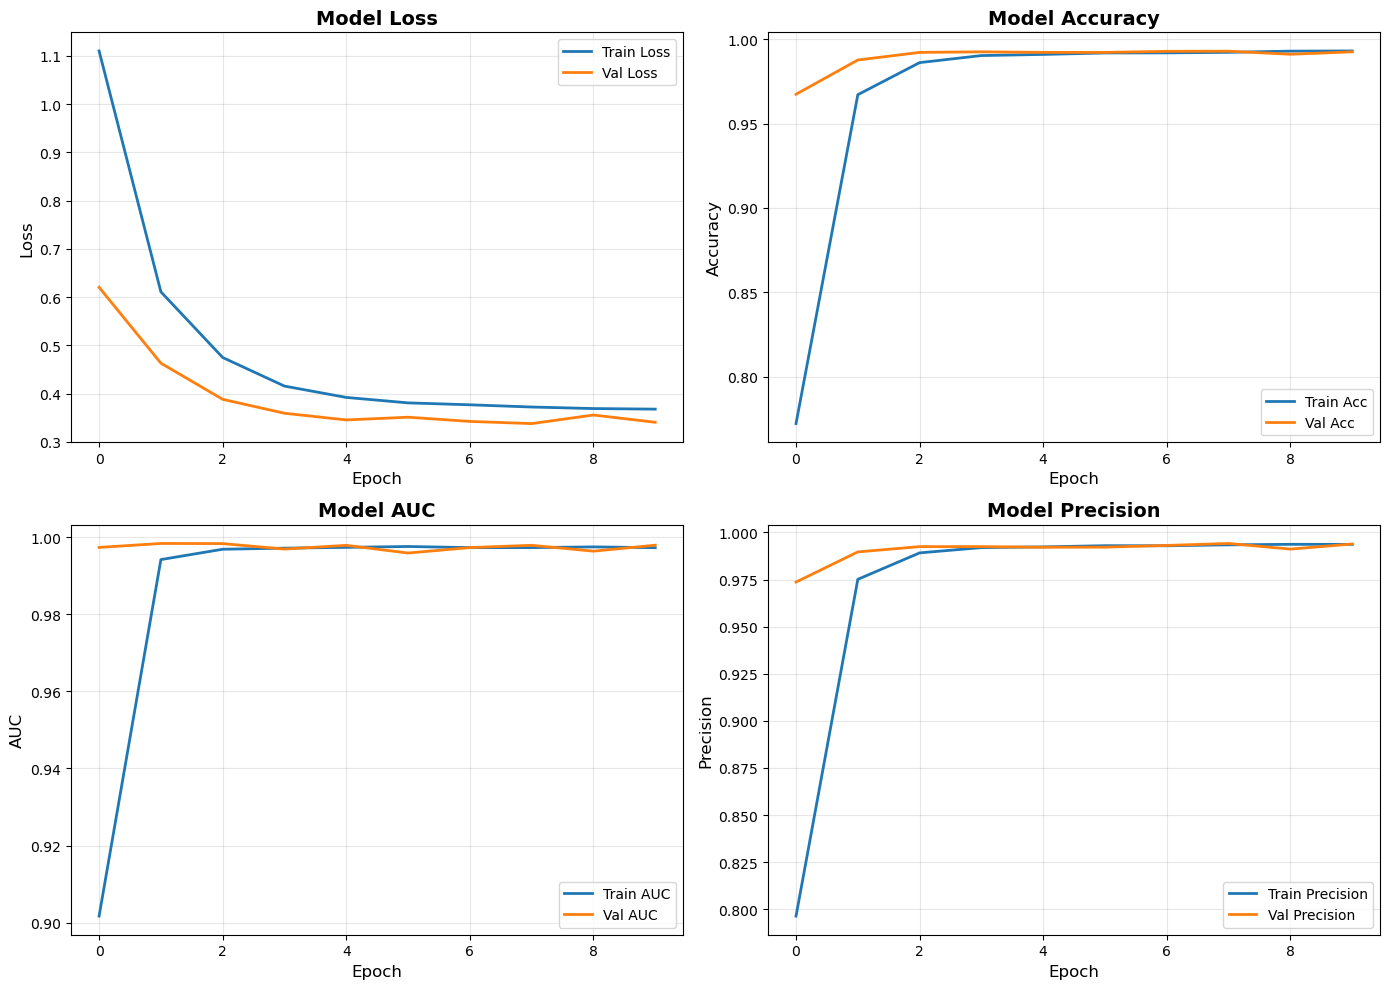


Classification Report:
              precision    recall  f1-score   support

    ENHANCER     1.0000    0.9833    0.9916      7226
    PROMOTER     0.9957    1.0000    0.9979      7226
  INTERGENIC     0.9877    1.0000    0.9938      7227

    accuracy                         0.9944     21679
   macro avg     0.9945    0.9944    0.9944     21679
weighted avg     0.9945    0.9944    0.9944     21679



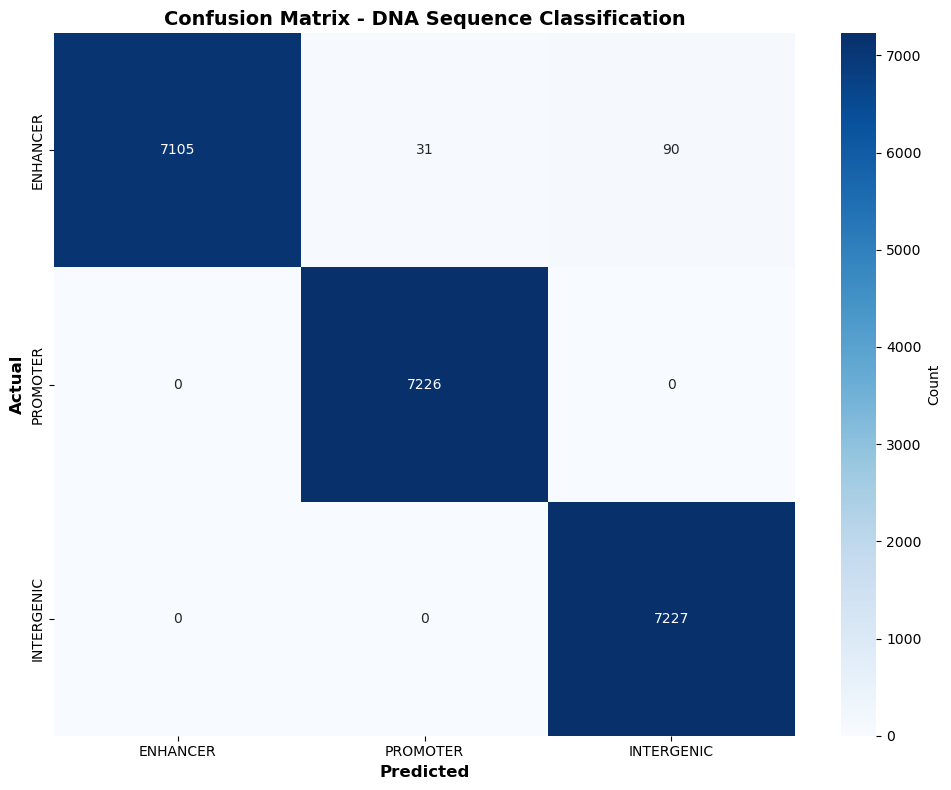

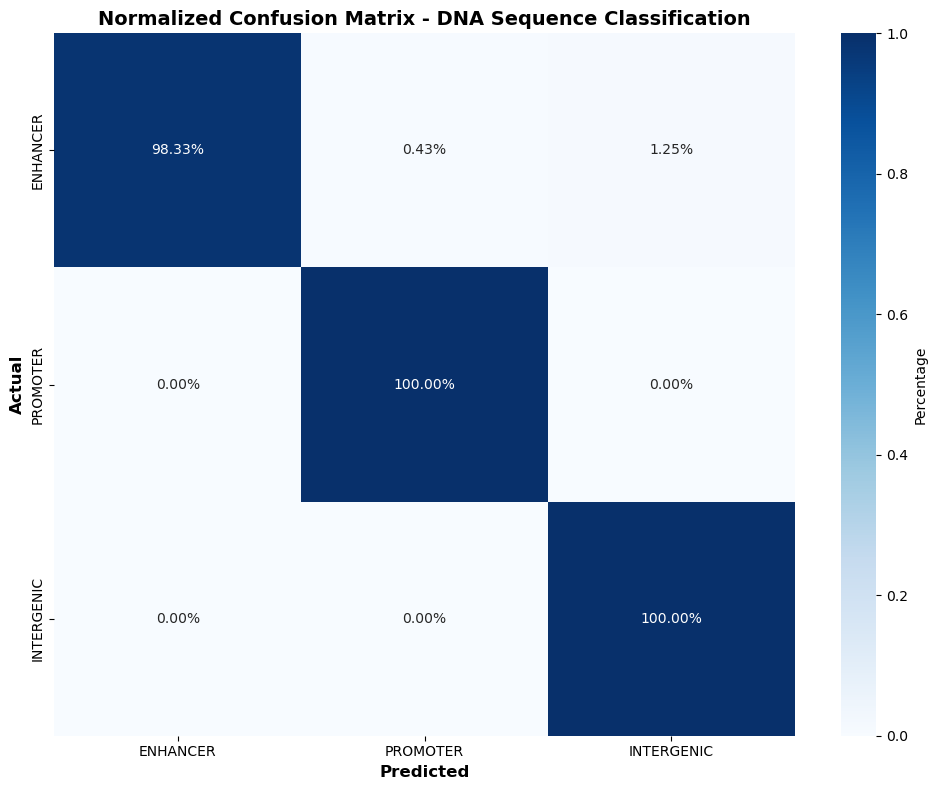


Per-Class Performance:
  ENHANCER: 98.33% (7226 samples)
  PROMOTER: 100.00% (7226 samples)
  INTERGENIC: 100.00% (7227 samples)

Sample Predictions:
  ✓ True: ENHANCER     | Predicted: ENHANCER     | Confidence: 92.24%
  ✓ True: INTERGENIC   | Predicted: INTERGENIC   | Confidence: 94.46%
  ✓ True: PROMOTER     | Predicted: PROMOTER     | Confidence: 95.19%
  ✓ True: ENHANCER     | Predicted: ENHANCER     | Confidence: 91.65%
  ✓ True: ENHANCER     | Predicted: ENHANCER     | Confidence: 92.60%
  ✓ True: PROMOTER     | Predicted: PROMOTER     | Confidence: 96.58%
  ✓ True: PROMOTER     | Predicted: PROMOTER     | Confidence: 95.53%
  ✓ True: INTERGENIC   | Predicted: INTERGENIC   | Confidence: 94.01%
  ✓ True: ENHANCER     | Predicted: ENHANCER     | Confidence: 92.27%
  ✓ True: INTERGENIC   | Predicted: INTERGENIC   | Confidence: 94.08%


In [9]:
# Evaluate on test set - unpack all metrics
test_results = model.evaluate(X_test_cnn_ohe, y_test_cat)

# The model returns: [loss, accuracy, auc, precision, recall]
test_loss = test_results[0]
test_acc = test_results[1]
test_auc = test_results[2]
test_precision = test_results[3]
test_recall = test_results[4]

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  AUC: {test_auc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")

# Make predictions
predictions = model.predict(X_test_cnn_ohe)
predicted_classes = predictions.argmax(axis=1)

# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# AUC
axes[1, 0].plot(history.history['auc'], label='Train AUC', linewidth=2)
axes[1, 0].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('AUC', fontsize=12)
axes[1, 0].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Precision
axes[1, 1].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 1].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Precision', fontsize=12)
axes[1, 1].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_test_classes = y_test_cat.argmax(axis=1)

# Define class names for better readability
class_names = ['ENHANCER', 'PROMOTER', 'INTERGENIC']

print("\nClassification Report:")
print(classification_report(
    y_test_classes, 
    predicted_classes,
    target_names=class_names,
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(y_test_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - DNA Sequence Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional visualization: Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2%', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Percentage'}
)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Normalized Confusion Matrix - DNA Sequence Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Per-class performance analysis
print("\nPer-Class Performance:")
for i, class_name in enumerate(class_names):
    class_mask = (y_test_classes == i)
    class_acc = (predicted_classes[class_mask] == i).sum() / class_mask.sum()
    print(f"  {class_name}: {class_acc:.2%} ({class_mask.sum()} samples)")

# Show some example predictions
print("\nSample Predictions:")
for i in range(min(10, len(predicted_classes))):
    true_class = class_names[y_test_classes[i]]
    pred_class = class_names[predicted_classes[i]]
    confidence = predictions[i][predicted_classes[i]]
    match = "✓" if y_test_classes[i] == predicted_classes[i] else "✗"
    print(f"  {match} True: {true_class:12s} | Predicted: {pred_class:12s} | Confidence: {confidence:.2%}")


--- Step 4: Final Evaluation ---
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


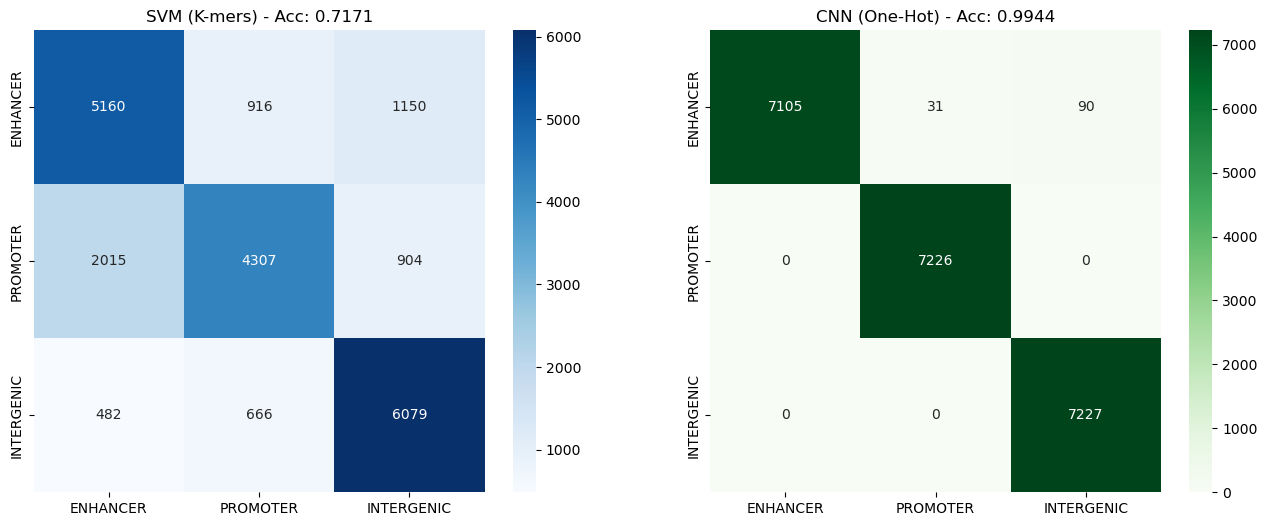


--- Detailed Report (CNN) ---
              precision    recall  f1-score   support

    ENHANCER       1.00      0.98      0.99      7226
    PROMOTER       1.00      1.00      1.00      7226
  INTERGENIC       0.99      1.00      0.99      7227

    accuracy                           0.99     21679
   macro avg       0.99      0.99      0.99     21679
weighted avg       0.99      0.99      0.99     21679



In [11]:
print("\n--- Step 4: Final Evaluation ---")

# קבלת התחזיות מהרשת
y_pred_cnn_probs = model.predict(X_test_cnn_ohe)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)
acc_cnn = accuracy_score(y_test, y_pred_cnn)

# מטריצות בלבול (Confusion Matrices)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
labels = [LABEL_MAP[i] for i in range(3)]

# SVM Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title(f'SVM (K-mers) - Acc: {acc_svm:.4f}')

# CNN Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f'CNN (One-Hot) - Acc: {acc_cnn:.4f}')

plt.show()

# הדפסת דוח מפורט
print("\n--- Detailed Report (CNN) ---")
print(classification_report(y_test, y_pred_cnn, target_names=labels))

In [12]:
model.save('dna_cnn_model.keras')